In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error

import warnings
warnings.filterwarnings("ignore")

import joblib

In [2]:
train = pd.read_csv("../kaggle/input/playground-series-s4e12/train.csv")
test = pd.read_csv("../kaggle/input/playground-series-s4e12/test.csv")

sample = pd.read_csv('../kaggle/input/playground-series-s4e12/sample_submission.csv')

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True) 

In [3]:
def date(Df):

    Df['Policy Start Date'] = pd.to_datetime(Df['Policy Start Date'])
    Df['Year'] = Df['Policy Start Date'].dt.year
    Df['Day'] = Df['Policy Start Date'].dt.day
    Df['Month'] = Df['Policy Start Date'].dt.month
    Df['Month_name'] = Df['Policy Start Date'].dt.month_name()
    Df['Day_of_week'] = Df['Policy Start Date'].dt.day_name()
    Df['Week'] = Df['Policy Start Date'].dt.isocalendar().week
    Df['Year_sin'] = np.sin(2 * np.pi * Df['Year'])
    Df['Year_cos'] = np.cos(2 * np.pi * Df['Year'])
    Df['Month_sin'] = np.sin(2 * np.pi * Df['Month'] / 12) 
    Df['Month_cos'] = np.cos(2 * np.pi * Df['Month'] / 12)
    Df['Day_sin'] = np.sin(2 * np.pi * Df['Day'] / 31)  
    Df['Day_cos'] = np.cos(2 * np.pi * Df['Day'] / 31)
    Df['Group']=(Df['Year']-2020)*48+Df['Month']*4+Df['Day']//7
    
    Df.drop('Policy Start Date', axis=1, inplace=True)

    return Df

In [4]:
train = date(train)
test = date(test)

# cat_c = [col for col in train.columns if train[col].dtype == 'object']

# def update(df):
#     global cat_c

#     for c in cat_c:
#         df[c] = df[c].fillna('None').astype('category')
                
#     return df

# train = update(train)
# test = update(test)

columns_to_convert = train.columns.difference(['Premium Amount'])

train[columns_to_convert] = train[columns_to_convert].fillna('None').astype('string')
test[columns_to_convert] = test[columns_to_convert].fillna('None').astype('string')

In [5]:
X = train.drop('Premium Amount', axis=1)  
y = train['Premium Amount']
cat_features = X.columns.values

In [6]:
cat_features

array(['Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation',
       'Health Score', 'Location', 'Policy Type', 'Previous Claims',
       'Vehicle Age', 'Credit Score', 'Insurance Duration',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Year', 'Day', 'Month', 'Month_name',
       'Day_of_week', 'Week', 'Year_sin', 'Year_cos', 'Month_sin',
       'Month_cos', 'Day_sin', 'Day_cos', 'Group'], dtype=object)

In [7]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [8]:
def train():
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    oof = np.zeros(len(X))
    models = []

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}")
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = CatBoostRegressor(
            iterations=1000,
            learning_rate=0.1,
            depth=6,
            eval_metric="RMSE",
            random_seed=42,
            verbose=200,
            task_type='GPU',
            l2_leaf_reg =  0.7,
        )
        
        model.fit(X_train,
                  y_train,
                  eval_set=(X_valid, y_valid), 
                  early_stopping_rounds=300,
                  cat_features=cat_features,
                 )
        models.append(model)
        oof[valid_idx] = np.maximum(0, model.predict(X_valid))
        fold_rmsle = rmsle(y_valid, oof[valid_idx])
        print(f"Fold {fold + 1} RMSLE: {fold_rmsle}")
        
    return models, oof

In [9]:
models,oof = train()

Fold 1
0:	learn: 863.0919080	test: 862.0243288	best: 862.0243288 (0)	total: 7.58s	remaining: 2h 6m 11s
200:	learn: 843.7871100	test: 839.4356962	best: 839.4356962 (200)	total: 2m 30s	remaining: 9m 59s
400:	learn: 842.4902566	test: 838.9332859	best: 838.9325128 (398)	total: 11m 36s	remaining: 17m 20s
600:	learn: 841.4690697	test: 838.7485484	best: 838.7438684 (584)	total: 15m 57s	remaining: 10m 35s
800:	learn: 840.4436771	test: 838.6231561	best: 838.6173764 (755)	total: 18m 51s	remaining: 4m 41s
999:	learn: 839.5975163	test: 838.5951122	best: 838.5946237 (993)	total: 19m 32s	remaining: 0us
bestTest = 838.5946237
bestIteration = 993
Shrink model to first 994 iterations.
Fold 1 RMSLE: 1.1429558641333812
Fold 2
0:	learn: 863.4064924	test: 861.3107382	best: 861.3107382 (0)	total: 121ms	remaining: 2m
200:	learn: 843.9066388	test: 838.1817935	best: 838.1817935 (198)	total: 25.4s	remaining: 1m 40s
400:	learn: 842.5181304	test: 837.6399201	best: 837.6399201 (400)	total: 55.3s	remaining: 1m 22s


In [10]:
print(rmsle(y, oof))

1.1418404277486618


In [11]:
test_predictions = np.zeros(len(test))

for model in models:
    test_predictions += np.maximum(0, model.predict(test)) / len(models)


sample['Premium Amount'] = test_predictions
sample.to_csv('submission.csv', index = False)

joblib.dump([oof,test_predictions],"cat_non_loged.pkl")

['cat_non_loged.pkl']

In [12]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [22]:
test_predictions.shape
test_predictions

array([1286.68366885, 1290.51494717, 1095.78766093, ..., 1148.49131115,
       1412.46779348, 1085.89056324])

In [23]:
oof.shape
oof

array([1157.34922586,  986.69834566, 1107.17911711, ...,  549.76856307,
       1232.3760534 ,  952.99334895])

In [25]:
non_log_oof, non_log_test = joblib.load(
    '../kaggle/input/cat_non_loged_origin.pkl'
)

In [3]:
res=pd.read_pickle('../kaggle/input/cat_non_loged.pkl').values
a=res[:-800000]
b=res[-800000:]

In [6]:
joblib.dump([a,b],"cat_non_loged.pkl")

['cat_non_loged.pkl']

In [26]:
oof

array([1157.34922586,  986.69834566, 1107.17911711, ...,  549.76856307,
       1232.3760534 ,  952.99334895])

In [27]:
non_log_oof

array([1198.81605661,  953.27201574, 1104.08346901, ...,  544.03830381,
       1235.85765329,  968.17722088])

<Axes: >

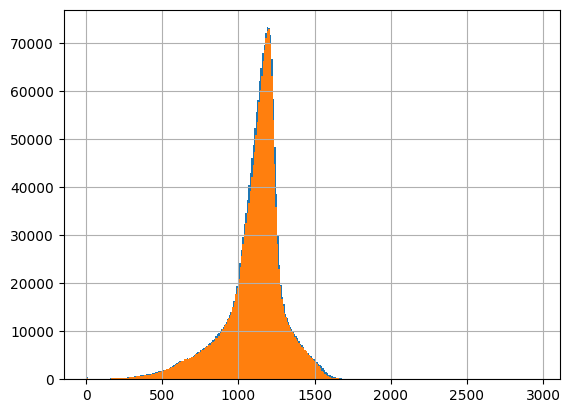

In [28]:
m=pd.Series(np.hstack([oof, test_predictions]))#.to_pickle('cat_non_loged.pkl')
o=pd.Series(np.hstack([non_log_oof, non_log_test]))#.to_pickle('cat_non_loged_origin.pkl')
m.hist(bins=300)
o.hist(bins=300)

<Axes: >

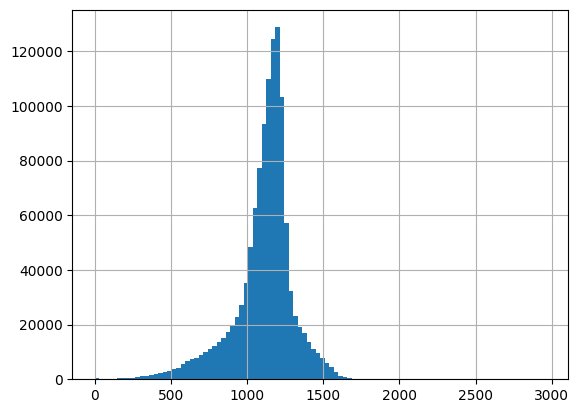

In [14]:
pd.Series(oof).hist(bins=100)